In [1]:
using Pkg
Pkg.activate(".")

using OrdinaryDiffEq

include("Y_matrix_code.jl")
include("PowerFlow_SMIB.jl")

using .YMatrix
using .PowerFlow

  Activating project at `~/repos/JuliaPSS2`


In [25]:
begin
    n_bus = 3
    n_lines = 2

    v_10 = 1.03
    v_2 = 1.0
    θ_2 = 0.0


    R1 = 0.015
    # R1 = 1e-18
    XL1 = 0.15

    R2 = 0.0198
    # R2 = 1e-18
    XL2 = 0.198

    
    Z_dict = Dict([("R1", R1),
                   ("R2", R2),
                   ("XL1", XL1),
                   ("XL2", XL2)])

    fault_dict = Dict([("Rs", 0),
                       ("XLs", 1e-3),
                       ("tf", 100*1e-3),
                       ("tc",100*1e-3 + 0.1),
                       ("tspan", 0.5)])

    
    param_dict = Dict([("Gen Model", "CLS"),
                      ("Framework","DP Full"),
                      ("dt", "Fixed"),
                      ("step_size",1e-3)])
    
    # plot_dict = Dict([("Interpolate", 1),
    #                   ("Overlay",1)])

    u0 = [v_10,v_2,θ_2]

    bus_impedance = Dict((1,3) => R1+XL1*1im,
                         (2,3) => R2+XL2*1im)
    # # #                      (3,3) => 0.01+0im)

    Y = build_Y(bus_impedance,n_bus)

    params = (Y, Z_dict, fault_dict, param_dict)

end

(ComplexF64[0.6600660066006601 - 6.600660066006601im 0.0 + 0.0im -0.6600660066006601 + 6.600660066006601im; 0.0 + 0.0im 0.5000500050005 - 5.000500050005im -0.5000500050005 + 5.000500050005im; -0.6600660066006601 + 6.600660066006601im -0.5000500050005 + 5.000500050005im 1.16011601160116 - 11.6011601160116im], Dict("XL1" => 0.15, "R1" => 0.015, "XL2" => 0.198, "R2" => 0.0198), Dict{String, Real}("Rs" => 0, "tc" => 0.2, "tspan" => 0.5, "tf" => 0.1, "XLs" => 0.001), Dict{String, Any}("Gen Model" => "CLS", "Framework" => "DP Full", "dt" => "Fixed", "step_size" => 0.001))

In [26]:
u_pf = solve_powerflow(Y, u0)

┌ Warning: Rosenbrock methods on equations without differential states do not bound the error on interpolations.
└ @ OrdinaryDiffEq /home/aaliqureshi/.julia/packages/OrdinaryDiffEq/NBaQM/src/solve.jl:105


Success


6-element Vector{Float64}:
 0.3194800988544246
 1.004422950206025
 0.18428849279891663
 1.03
 1.0
 0.0

In [27]:
function fxinit!(du,u,p,t)
    δ,ω,e_q_prime,i_d,i_q,i_32d,i_32q = u

    Y = p[1]
    Z = p[2]
    θ_1, v_3, θ_3, v_1, v_2, θ_2 = p[3]

    R1 = Z["R1"]
    R2 = Z["R2"]
    w_L1 = Z["XL1"]
    w_L2 = Z["XL2"]
    
    x_d_prime = 0.24
    p_m = 0.944
    H = 3.5

    Ω = 2π*60
    d = 0

    Y_abs = abs.(Y)
    Y_ang = angle.(Y)

    y_11 = Y_abs[1,1]
    y_12 = Y_abs[1,2]
    y_13 = Y_abs[1,3]
    y_21 = Y_abs[2,1]
    y_22 = Y_abs[2,2]
    y_23 = Y_abs[2,3]
    y_31 = Y_abs[3,1]
    y_32 = Y_abs[3,2]
    y_33 = Y_abs[3,3]

    ϕ_11 = Y_ang[1,1]
    ϕ_12 = Y_ang[1,2]
    ϕ_13 = Y_ang[1,3]
    ϕ_21 = Y_ang[2,1]
    ϕ_22 = Y_ang[2,2]
    ϕ_23 = Y_ang[2,3]
    ϕ_31 = Y_ang[3,1]
    ϕ_32 = Y_ang[3,2]
    ϕ_33 = Y_ang[3,3]

    du[1] = Ω*(ω-1)
    du[2] = (p_m - (i_d*v_1*cos(θ_1) + i_q*v_1*sin(θ_1)) - d*(ω-1))/(2H)
    du[3] = v_1*cos(θ_1) - x_d_prime*i_q + e_q_prime*sin(δ-π/2)
    du[4] = v_1*sin(θ_1) - e_q_prime*cos(δ-π/2) + i_d*x_d_prime
    du[5] = i_d - (v_1*y_11*cos(θ_1 + ϕ_11) + v_2*y_12*cos(θ_2 + ϕ_12) + v_3*y_13*cos(θ_3 + ϕ_13))
    # du[5] = (i_d*v_1*cos(θ_1) + i_q*v_1*sin(θ_1)) - (v_1*v_1*y_11*cos(θ_1 - θ_1 -ϕ_11) + v_1*v_2*y_12*cos(θ_1 - θ_2 -ϕ_12) + v_1*v_3*y_13*cos(θ_1 - θ_3 -ϕ_13))
    du[6] = i_32d - (v_3*sin(θ_3) - v_2*sin(θ_2) - R2*i_32q)/(w_L2)
    du[7] = i_32q - (-v_3*cos(θ_3) + v_2*cos(θ_2) + R2*i_32d)/(w_L2)

end

fxinit! (generic function with 1 method)

In [28]:
Y, Z_dict, fault_dict, param_dict = params

M0 = zeros(7,7)
tspan0 = (0.0,5)

# δ,ω,e_q_prime,i_d,i_q,i_32d,i_32q
u0_init = ones(7);

f0 = ODEFunction(fxinit!,mass_matrix=M0)

θ_10, v_30, θ_30, v_10, v_20, θ_20 = u_pf

p0_init = (Y,Z_dict,u_pf)

(ComplexF64[0.6600660066006601 - 6.600660066006601im 0.0 + 0.0im -0.6600660066006601 + 6.600660066006601im; 0.0 + 0.0im 0.5000500050005 - 5.000500050005im -0.5000500050005 + 5.000500050005im; -0.6600660066006601 + 6.600660066006601im -0.5000500050005 + 5.000500050005im 1.16011601160116 - 11.6011601160116im], Dict("XL1" => 0.15, "R1" => 0.015, "XL2" => 0.198, "R2" => 0.0198), [0.3194800988544246, 1.004422950206025, 0.18428849279891663, 1.03, 1.0, 0.0])

In [29]:
prob0 = ODEProblem(f0,u0_init,tspan0,p0_init)
sol0 = solve(prob0,Rodas5(),reltol=1e-8)

δ0,ω0,e_q_prime0,i_d0,i_q0,i_32d0,i_32q0 = sol0.u[end]

┌ Warning: Rosenbrock methods on equations without differential states do not bound the error on interpolations.
└ @ OrdinaryDiffEq /home/aaliqureshi/.julia/packages/OrdinaryDiffEq/NBaQM/src/solve.jl:105


7-element Vector{Float64}:
 0.5234150168964284
 1.0
 1.0860978344878298
 0.9140869456592338
 0.15496961898679446
 0.9140869456592343
 0.1549696189867984

In [30]:
v_1 = v_10*exp(im*θ_10)
v_2 = v_20*exp(im*θ_20)
v_3 = v_30*exp(im*θ_30)

v_1d0 = real(v_1)
v_1q0 = imag(v_1)

v_2d0 = real(v_2)
v_2q0 = imag(v_2)

v_3d0 = real(v_3)
v_3q0 = imag(v_3)

i_30d0 = 0
i_30q0 = 0

i_13d0 = i_d0
i_13q0 = i_q0

# res = [δ0,ω0,i_13d0,i_13q0,i_32d0,i_32q0,i_30d0,i_30q0,v_1d0,v_1q0,v_3d0,v_3q0]

u0 = [δ0,ω0,i_13d0,i_13q0,i_32d0,i_32q0,v_1d0,v_1q0,v_3d0,v_3q0]

10-element Vector{Float64}:
 0.5234150168964284
 1.0
 0.9140869456592338
 0.15496961898679446
 0.9140869456592343
 0.1549696189867984
 0.9778807983015357
 0.32349519983015396
 0.9874149369646668
 0.18405761369646703

In [31]:
function fx!(du,u,p,t)
    δ,ω,i_13d,i_13q,i_32d,i_32q,v_1d,v_1q,v_3d,v_3q = u

    Z, fault_dict, k, e_q_prime0 = p
    
    e_q_prime = e_q_prime0
    x_d_prime = 0.24
    p_m = 0.944
    H = 3.5
    Ω = 2π*60
    
    d = 1

    R1 = Z["R1"]
    R2 = Z["R2"]
    w_L1 = Z["XL1"]
    w_L2 = Z["XL2"]

    w_L3 = fault_dict["XLs"]
    R3 = fault_dict["Rs"]



    L1 = w_L1/Ω
    L2 = w_L2/Ω
    L3 = w_L3/Ω

    Rs = k*R3 + abs(k-1)*1e100
    Ls = k*L3 + abs(k-1)*1e100

    y_f = 1/(Rs + 1im*Ω*Ls)
    g_f = real(y_f)
    b_f = imag(y_f)

    v_3 = abs(v_3d + 1im*v_3q)

    p_fault = (v_3^2)*abs(y_f)*cos(-1*angle(y_f))
    q_fault = (v_3^2)*abs(y_f)*sin(-1*angle(y_f))

    p_l3 = -p_fault
    q_l3 = -q_fault

    v_2 = 1.0
    θ_2 = 0.0

    v_2 = v_2*exp(im*θ_2)

    v_2d = real(v_2)
    v_2q = imag(v_2)


    du[1] = Ω*(ω-1)
    du[2] = (p_m - (v_1d*i_13d + v_1q*i_13q) - d*(ω-1))/(2H)

    # # ## d(i_13)/dt
    # du[3] = v_1d/L1 - v_3d/L1 - R1*((e_q_prime*cos(δ - π/2) - v_1q)/x_d_prime)/L1 + Ω*((e_q_prime*sin(δ - π/2) + v_1d)/x_d_prime)
    # du[4] = v_1q/L1 - v_3q/L1 - R1*((e_q_prime*sin(δ - π/2) + v_1d)/x_d_prime)/L1 - Ω*((e_q_prime*cos(δ - π/2) - v_1q)/x_d_prime)

    du[3] = v_1d/L1 - v_3d/L1 - R1*i_13d/L1 + Ω*i_13q
    du[4] = v_1q/L1 - v_3q/L1 - R1*i_13q/L1 - Ω*i_13d

    # # # ## d(i_32)/dt
    du[5] = v_3d/L2 - v_2d/L2 - R2*i_32d/L2 + Ω*i_32q
    du[6] = v_3q/L2 - v_2q/L2 - R2*i_32q/L2 - Ω*i_32d
    
    # # # ## L3 equation
    # du[7] = v_3d/Ls - Rs*i_30d/Ls + Ω*i_30q
    # du[8] = v_3q/Ls - Rs*i_30q/Ls - Ω*i_30d


    # du[7]  = v_1d - x_d_prime*i_13q + e_q_prime*sin(δ-π/2)
    # du[8] = v_1q - e_q_prime*cos(δ-π/2) + i_13d*x_d_prime

    ## power balance at bus 1

    du[7] = (v_1d*i_13d + v_1q*i_13q) - (((e_q_prime*cos(δ - π/2) - v_1q)/x_d_prime)*v_1d + ((e_q_prime*sin(δ - π/2) + v_1d)/x_d_prime)*v_1q)
    du[8] = (i_13d*v_1q - i_13q*v_1d) - (((e_q_prime*cos(δ - π/2) - v_1q)/x_d_prime)*v_1q - ((e_q_prime*sin(δ - π/2) + v_1d)/x_d_prime)*v_1d)



    
    ## power balance at bus 3
    du[9] =  p_l3 - (-i_13d*v_3d - i_13q*v_3q + i_32d*v_3d + i_32q*v_3q)
    du[10] = q_l3 - (-i_13d*v_3q + i_13q*v_3d + i_32d*v_3q - i_32q*v_3d)


end #function

fx! (generic function with 1 method)

In [34]:
M = zeros(10,10)

for i = 1:6
    M[i,i] = 1
end

t_span=(0.0,fault_dict["tspan"])

k = 0
p = [Z_dict,fault_dict,k,e_q_prime0]

prob0 = ODEFunction(fx!,mass_matrix = M)

prob = ODEProblem(prob0,u0,t_span,p);

In [35]:
function condition1(u,t,integrator,save_positions=(true,true))
    t in event_time1
end

function condition2(u,t,integrator,save_positions=(true,true))
    t in event_time2
end

function affect1!(integrator)
    @show "entering affect1"
    @show integrator.t
    integrator.p[3] = 0

    u_modified!(integrator,true)
end

function affect2!(integrator)
    @show "entering affect2"
    @show integrator.t
    
    integrator.p[3] = 1

    u_modified!(integrator,true)
end

global event_time1 = fault_dict["tf"]
global event_time2 = fault_dict["tc"]

tstop2 = [event_time1;event_time2]

cb1 = DiscreteCallback(condition1,affect1!)
cb2 = DiscreteCallback(condition2,affect2!)

cbs2 = CallbackSet(cb1,cb2)

CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(condition1), typeof(affect1!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(condition2), typeof(affect2!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}((), (DiscreteCallback{typeof(condition1), typeof(affect1!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition1, affect1!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1]), DiscreteCallback{typeof(condition2), typeof(affect2!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition2, affect2!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])))

In [36]:
sol = solve(prob, Rosenbrock23(autodiff=false), callback=cbs2, tstops=tstop2, dt = 50e-6, adaptive = false, abstol = 1e-12)

"entering affect1" = "entering affect1"
integrator.t = 0.1
"entering affect2" = "entering affect2"
integrator.t = 0.2


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aaliqureshi/.julia/packages/SciMLBase/2HZ5m/src/integrator_interface.jl:602


retcode: Unstable
Interpolation: specialized 2nd order "free" stiffness-aware interpolation
t: 4010-element Vector{Float64}:
 0.0
 5.0e-5
 0.0001
 0.00015000000000000001
 0.0002
 0.00025
 0.00030000000000000003
 0.00035000000000000005
 0.0004000000000000001
 0.0004500000000000001
 ⋮
 0.199949999999989
 0.199999999999989
 0.2
 0.2
 0.20005
 0.2001
 0.20015
 0.2002
 0.20024999999999998
u: 4010-element Vector{Vector{Float64}}:
 [0.5234150168964284, 1.0, 0.9140869456592338, 0.15496961898679446, 0.9140869456592343, 0.1549696189867984, 0.9778807983015357, 0.32349519983015396, 0.9874149369646668, 0.18405761369646703]
 [0.5234150168964284, 1.0, 0.9140869456592342, 0.15496961898679665, 0.914086945659234, 0.15496961898679673, 0.9778807983015362, 0.3234951998301539, 0.9874149369646793, 0.18405761369655488]
 [0.5234150168964284, 1.0, 0.9140869456592341, 0.15496961898679668, 0.9140869456592341, 0.1549696189867967, 0.9778807983015361, 0.323495199830154, 0.987414936964661, 0.18405761369646947]
 [0.52

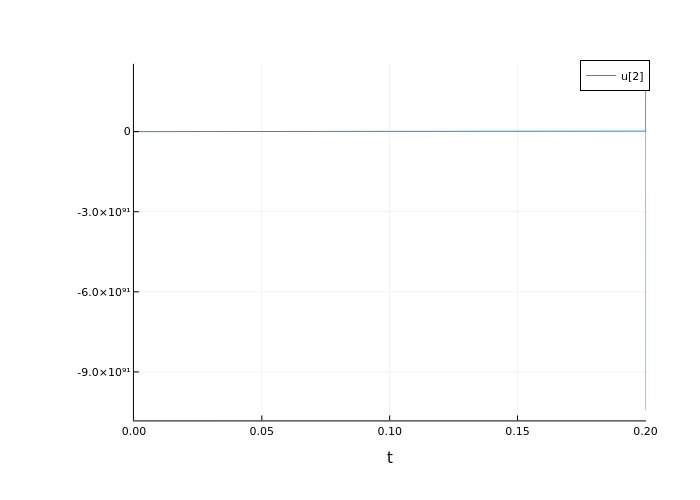

In [37]:
using Plots
plot(sol,idxs=2)

In [38]:
v3 = abs.(sol[9,:] + 1im*sol[10,:])

4010-element Vector{Float64}:
 1.004422950206025
 1.0044229502060533
 1.0044229502060196
 1.0044229502060276
 1.0044229502060262
 1.0044229502060216
 1.0044229502060238
 1.0044229502060182
 1.004422950206027
 1.0044229502060293
 ⋮
 1.0044229502060256
 1.0044229502060207
 1.0045428012544435
 1.0045428012544435
 1.0567956118922713e6
 4.082808567398962e20
 3.004352611332725e35
 8.252760835817153e49
 2.0998303097437256e63

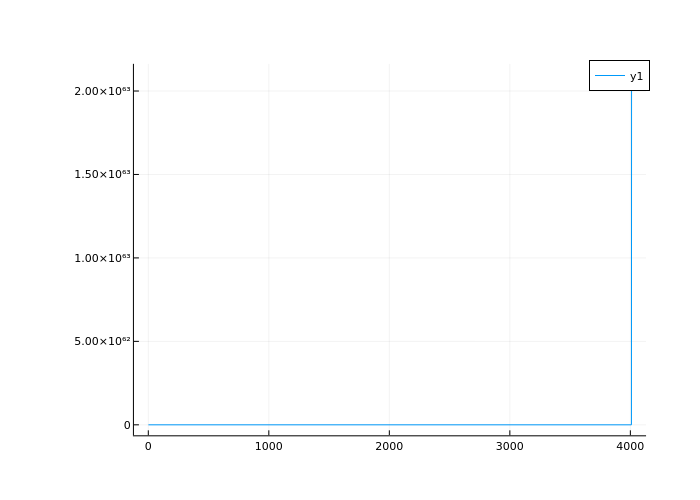

In [39]:
plotlyjs()
plot(v3)